In [1]:
%matplotlib widget
from collections import Counter
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from conops.common import unixtime2date
from conops.config import Config
from conops.ephemeris import compute_tle_ephemeris
from conops.pointing import Pointing
from conops.queue_ditl import QueueDITL
from conops.queue_scheduler import Queue

## DITL Configuration

### Set time period to run DITL over

In this example, we'll start on November 11, 2025 and run for 1 day.

In [2]:
length = 1
begin = datetime(2025, 11, 1)  # , tzinfo=timezone.utc)
end = begin + timedelta(days=length)

### Generate an Ephemeris for the time period

Using the TLE and the time period defined above, we generate an ephemeris for the spacecraft. This ephemeris will contain the position and velocity of the spacecraft for the entire simulation period, which is essential for determining what the spacecraft can see and when.


In [3]:
eph = compute_tle_ephemeris(
    begin=begin,
    end=end,
    tle="example.tle",
    step_size=60,
)

EOP2 text loaded from cache: /Users/jak51/.cache/rust_ephem/latest_eop2.short (age: 77985s)
UT1 provider initialized successfully (EOP2 short, cached)


### Configure the SpaceCraft Model for the DITL

Read in the Spacecraft configuration from JSON.


In [4]:
# Read JSON from disk
with open("example_config.json", "r") as json_in:
    json = json_in.read()

# Deserialize from JSON
config = Config.model_validate_json(json)

# Note that the ephemeris is not serialized, so we need to set it again
config.constraint.ephem = eph

### Ingest Targets for the DITL simulation

In this step we ingest targets into our simulation. This could be a list of
real science targets, an astronomical catalogue. For this simple example, we'll
just generate a list of random points on the sky.


In [5]:
number_of_targets = 1000
target_ra, target_dec = (
    np.random.uniform(0, 360, number_of_targets),
    np.random.uniform(-90, 90, number_of_targets),
)
print(f"Number of pointings = {len(target_ra)}")

Number of pointings = 1000


### Populate Target Queue

Take the list of targets, and use them to populate the Target `Queue`. This also
pre-calculates the visibility windows for each target. 

In [6]:
targids = list(range(10000, 10000 + len(target_ra)))

targlist = Queue()
targlist.ephem = eph
for i in tqdm(range(len(targids))):
    pointing = Pointing(
        constraint=config.constraint, acs_config=config.spacecraft_bus.attitude_control
    )
    pointing.merit = 40
    pointing.ra = target_ra[i]
    pointing.dec = target_dec[i]
    pointing.obsid = targids[i]
    pointing.name = f"pointing_{pointing.obsid}"
    pointing.exptime = 5000
    pointing.visibility()
    targlist.append(pointing)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Set up the Queue Scheduled DITL


In [7]:
# %%prun
ditls = list()
for i in range(1):
    targlist.reset()
    ditl = QueueDITL(config=config)
    ditl.acs.last_slew = None
    ditl.queue = targlist
    ditl.ephem = eph
    ditl.begin = begin
    ditl.end = end
    ditl.calc()
    ditls.append(ditl)

Scheduling groundstation passes...
Scheduled pass: 2025-305-07:56:00   NBO   8.0 mins
Scheduled pass: 2025-305-19:59:00   NBO   8.0 mins
Scheduled pass: 2025-305-22:00:00   NPO   8.0 mins
2025-305-00:00:00, RA: 16.02786745162226, Dec: 13.811909277581307, Mode: SCIENCE
2025-305-00:00:00 Fetching new PPT from Queue (last RA/Dec 0.00/0.00)
2025-305-00:00:00 Searching 83 targets in queue...
2025-305-00:00:00 Fetched PPT: 2025-305-00:00:00 pointing_10508 (10508) RA=92.6337, Dec=-34.195633, Roll=-1.0, Merit=100.9676843286813
2025-305-00:00:00: Enqueued SLEW_TO_TARGET command for execution  (queue size: 1)
2025-305-00:01:00: Executing SLEW_TO_TARGET command.
2025-305-00:01:00: Started slew to RA=92.63366838345257 Dec=-34.19563296911122
2025-305-00:01:00, RA: 30.461392961628913, Dec: 2.825447780342322, Mode: SLEWING
2025-305-00:02:00, RA: 69.50450622798404, Dec: -24.779560713625674, Mode: SLEWING
2025-305-00:03:00, RA: 92.39045331787807, Dec: -34.12090481380975, Mode: SLEWING
2025-305-00:04:00

### Check to see if any Battery charging events happened

In [8]:
# Check for emergency charging behavior
charging_cmds = [
    cmd
    for cmd in ditl.acs.executed_commands
    if "BATTERY_CHARGE" in cmd.command_type.name
]
print(f"Total battery charge commands: {len(charging_cmds)}")
for i, cmd in enumerate(charging_cmds[:20]):  # Show first 20
    print(f"{i}: {unixtime2date(cmd.execution_time)}: {cmd.command_type.name}")

# Check for CHG slews
# chg_slews = [s for s in ditl.acs.slew_history if hasattr(s, 'obstype') and s.obstype == 'CHG']
# print(f"\nTotal CHG slews: {len(chg_slews)}")
# for i, slew in enumerate(chg_slews[:10]):
#    print(f"{i}: RA={slew.endra:.1f} Dec={slew.enddec:.1f} obsid={slew.obsid}")

Total battery charge commands: 0


### Plot the output of the DITL simulation

This plot shows spacecraft RA/Dec over time, ACS mode, Battery Charge, Solar
Panel illumination, power level and observation ID

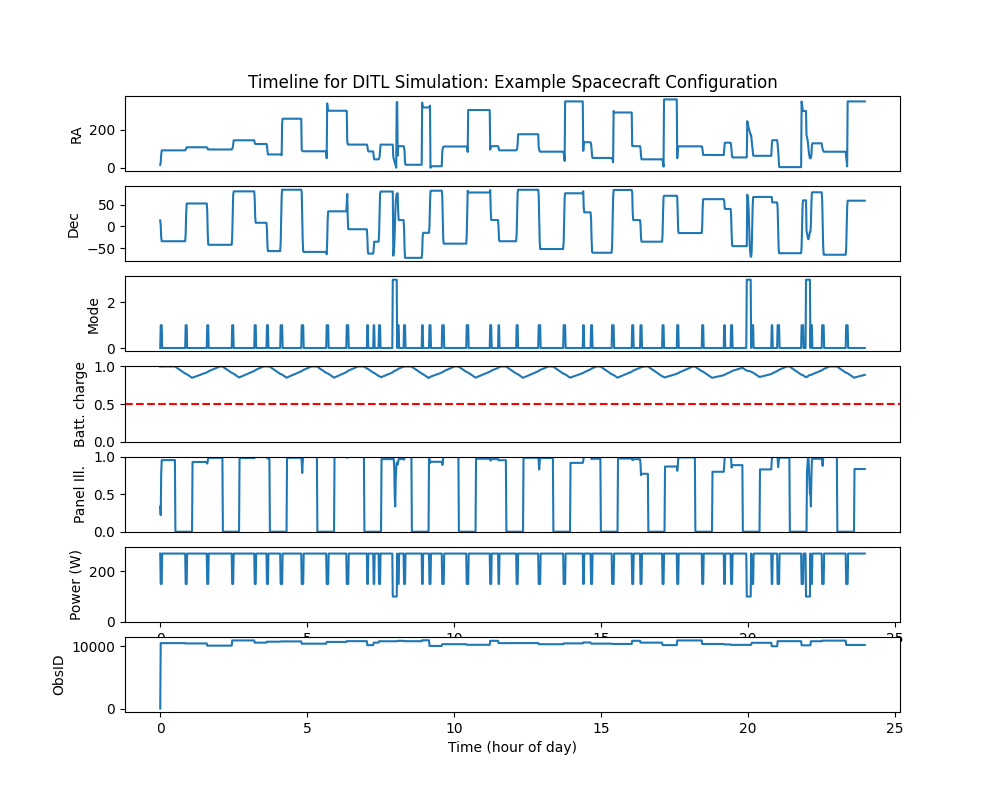

In [9]:
# Plot DITL results
ditl.plot()

### Plot a Histogram showing Observing Efficiency

This histogram plots the time in differing ACS modes, from which we can judge
the overall uptime for 

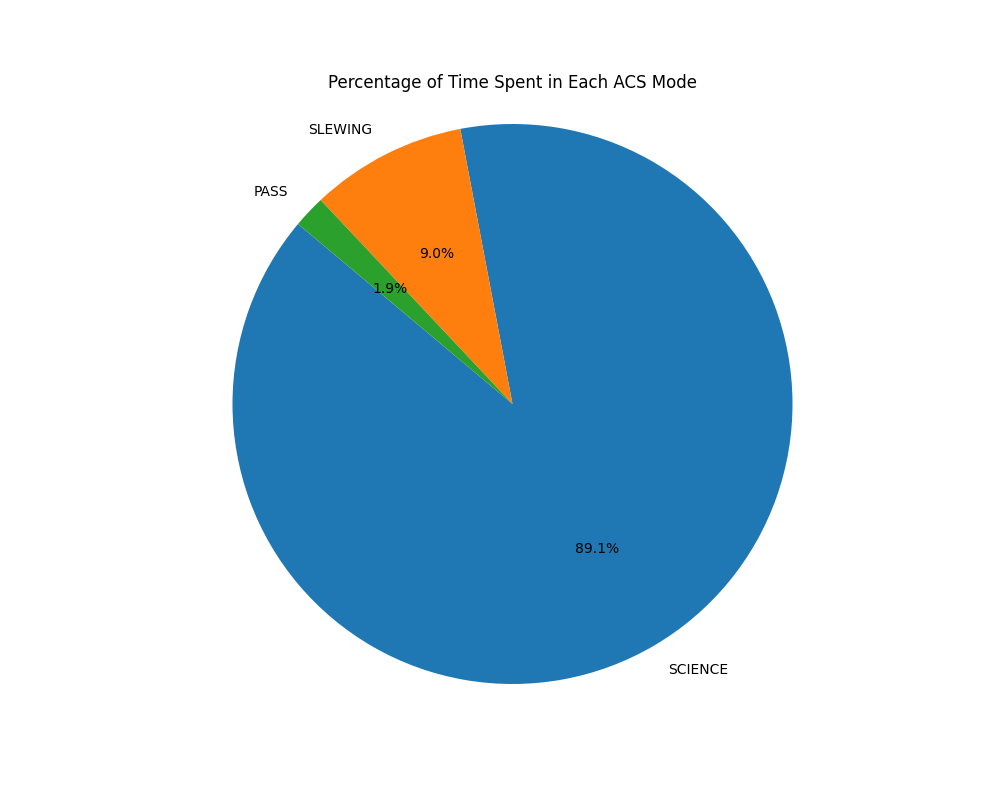

In [10]:
# Convert your data
times = [unixtime2date(t) for t in ditl.utime]
modes = [m.name for m in ditl.mode]
battery_levels = ditl.batterylevel  # unused in this example, but you can use later

# Count occurrences of each mode
mode_counts = Counter(modes)

# Prepare data for pie chart
labels = list(mode_counts.keys())
sizes = list(mode_counts.values())

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Percentage of Time Spent in Each ACS Mode")
plt.axis("equal")  # Equal aspect ratio ensures pie is a circle
plt.show()

In [11]:
print(f"Mean power generated: {np.mean(ditl.panel_power):.2f}W")
print(f"Mean power consumed: {np.mean(ditl.power):.2f}W")

Mean power generated: 269.04W
Mean power consumed: 255.98W


In [12]:
f"Power generation efficiency = {100 * np.mean(ditl.panel_power) / ditl.config.solar_panel.panels[0].max_power:.2f}%"

'Power generation efficiency = 56.73%'

In [13]:
eclipse_fraction = sum((np.array(ditl.panel_power) == 0).astype(int)) / len(
    ditl.panel_power
)
f"Time spent in eclipse: {100 * eclipse_fraction:.2f}%"

'Time spent in eclipse: 36.32%'

In [14]:
f"Total slewed in a day = {sum(ditl.acs.slew_dists):.1f} degrees"

'Total slewed in a day = 4440.3 degrees'

In [15]:
f"Median slew time = {np.median([ppt.slewtime for ppt in ditl.ppst])}s"

'Median slew time = 210.0s'

In [17]:
f"Median slew distance = {np.median(ditl.acs.slew_dists):.2f} degrees"

'Median slew distance = 108.10 degrees'

In [19]:
f"Total time in Slewing = {np.sum([ppt.slewtime for ppt in ditl.ppst])}s"

'Total time in Slewing = 8315s'